# Action Sequence Graph Tutorial

This tutorial covers use of the Action Sequence Graph in the FxnBlock class, which is useful for representing a Function's progress through a sequence of actions (e.g., modes of operation, etc)..

In [1]:
from fmdtools.define.mode import Mode
from fmdtools.define.block import FxnBlock, Action, ASG
from fmdtools.define.model import Model

import fmdtools.analyze as an
import fmdtools.sim.propagate as prop

Action sequence graphs are used within a function block to represent the actions that the function performs and their sequence. Actions in an ASG are respresented by `Action` blocks, which are similar to function and component blocks in that they have:
- flow connections
- modes, and
- behaviors

Flow connections are routed to the action in the function block definition and represent the *shared variables* between the actions.

Modes are similar to function modes and are instantiated (as they are in components) at both the Function and Action level. Using the `name=` option enables one to tag these modes as action modes at the function level while using the same local name

Below we define the states to performed by the ASG:
- Outcome, which tracks the number of actions and perceptions performed by the ASG
- HazardState, which specifies whether a hazard is present, percieved, or mitigated

In [2]:
from fmdtools.define.state import State
from fmdtools.define.flow import Flow

class OutcomeStates(State):
    num_perceptions: int=0
    num_actions:     int=0
class Outcome(Flow):
    _init_s = OutcomeStates
    
class HazardState(State):
    present:    bool=False
    percieved:  bool=False
    mitigated:  bool=False
class Hazard(Flow):
    _init_s = HazardState

Below we define three actions for use in a given model:
- Perceive, a user's perception abilities/behaviors. In this function the user percieves a hazard (unless their perception fails)
- Act, the user's action which they perform to mitigate the hazard.
- Done, the user's state when they are done performing the action.

In [3]:
class ActionMode(Mode):
    faultparams=('failed','unable')
    exclusive=True
class Perceive(Action):
    __slots__=('hazard', 'outcome')
    _init_m = ActionMode
    _init_hazard = Hazard
    _init_outcome = Outcome
    def behavior(self,time):
        if not self.m.in_mode('failed', 'unable'): 
            self.hazard.s.percieved = self.hazard.s.present
            self.outcome.s.num_perceptions+=self.hazard.s.percieved
        else:
            self.hazard.s.percieved = False
            self.m.remove_fault('failed', 'nom')
    def percieved(self):
        return self.hazard.s.percieved
class Act(Action):
    __slots__=('hazard', 'outcome')
    _init_m = ActionMode
    _init_hazard = Hazard
    _init_outcome = Outcome
    def behavior(self,time):
        if not self.m.in_mode('failed', 'unable'): 
            self.outcome.s.num_actions+=1
            self.hazard.s.mitigated=True
        elif self.m.in_mode('failed'): 
            self.hazard.s.mitigated=False
            self.m.remove_fault('failed', 'nom')
        else:
            self.hazard.s.mitigated=False
    def acted(self):
        return not self.m.in_mode('failed')
class Done(Action):
    __slots__=('hazard')
    _init_hazard = Hazard
    def behavior(self,time):
        if not self.hazard.s.present:
            self.hazard.s.mitigated=False
    def ready(self):
        return not self.hazard.s.present

To proceed through the sequence of actions, *conditions* must be met between each action. In these actions, we have defined the following conditions:
- Percieve.percieved: perception is done if the hazard is percieved
- Act.acted: the action is complete if the action was performed
- Done.complete: the hazard mitigation is over (and mitigated state is reset to False)

To create the overall ASG structure, the following adds the flows, actions, and conditions to the ASG class

In [4]:
class Human(ASG):
    initial_action="perceive"                  
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.add_flow("hazard", Hazard) # flows from external fxn/model can be defined here, 
        self.add_flow("outcome", fclass=Outcome) # along with flows internal to the ASG class
        
        self.add_act("perceive", Perceive, "outcome", "hazard")
        self.add_act("act", Act, "outcome", "hazard")
        self.add_act("done", Done, "hazard")
        
        self.add_cond("perceive", "act", "percieved", self.actions['perceive'].percieved)
        self.add_cond("act", "done", "acted", self.actions['act'].acted)
        self.add_cond("done","perceive", "ready", self.actions['done'].ready)
        self.build()

Note the use of the following methods:
- add_flow adds a flow so it can pass variables between actions. Here *Outcome* is an internal flow, while *Hazard* is an external flow.

In [5]:
help(ASG.add_flow)

Help on function add_flow in module fmdtools.define.block:

add_flow(self, flowname, fclass=<class 'fmdtools.define.flow.Flow'>, p={}, s={})
    Adds a flow with given attributes to ASG. Used to enable a flexible
    internal flow architecture in the ASG.
    
    Parameters
    ----------
    flowname : str
        Unique flow name to give the flow in the model
    fclass : Class, optional
        Class to instantiate (e.g. CommsFlow, MultiFlow). Default is Flow.
        Class must take flowname, flowdict, flowtype as input to __init__()
        May alternatively provide already-instanced object.
    p : dict, optional
        Parameter dictionary to instantiate the flow with
    s : dict, optional
        State dictionary to overwrite Flow default state values with



- add_act adds the action to the function and hands it the given flows and parameters. Here the actions are "Percieve", "Act", and "Done"

In [6]:
help(ASG.add_act)

Help on function add_act in module fmdtools.define.block:

add_act(self, name, actclass, *flownames, duration=0.0, **params)
    Associate an Action with the Function Block for use in the Action Sequence Graph
    
    Parameters
    ----------
    name : str
        Internal Name for the Action
    actclass : Action
        Action class to instantiate
    *flownames : flow
        Flows (optional) which connect the actions
    duration:
        Duration of the action. Default is 0.0
    **params : any
        parameters to instantiate the Action with.



- add_cond specifies the conditions for going from one action to another.

In [7]:
help(ASG.add_cond)

Help on function add_cond in module fmdtools.define.block:

add_cond(self, start_action, end_action, name='auto', condition='pass')
    Associates a Condition with the Function Block for use in the Action Sequence Graph
    
    Parameters
    ----------
    start_action : str
        Action where the condition is checked
    end_action : str
        Action that the condition leads to.
    name : str
        Name for the condition. Defaults to numbered conditions if none are provided.
    condition : method
        Method in the class to use as a condition. Defaults to self.condition_pass if none are provided



- ASG.build finally constructs the structure of the ASG (see: self.action_graph and self.flow_graph) and determines the settings for the simulation. In DetectHazard, default options are used, with the first action specified as "Percieve" and also with it specified that the actions propagate in the dynamic step (rather than static step)

In [8]:
help(ASG.build)

Help on function build in module fmdtools.define.block:

build(self)



We can look at the attributes of the `ASG` by instantiating it:

In [9]:
h = Human()
h

`ASGGraph` can also be used to visualize the flow of actions (e.g., which are active, flows vs conditions, etc.).

In [10]:
from fmdtools.analyze.graph import ASGGraph

In [11]:
ag = ASGGraph(h)

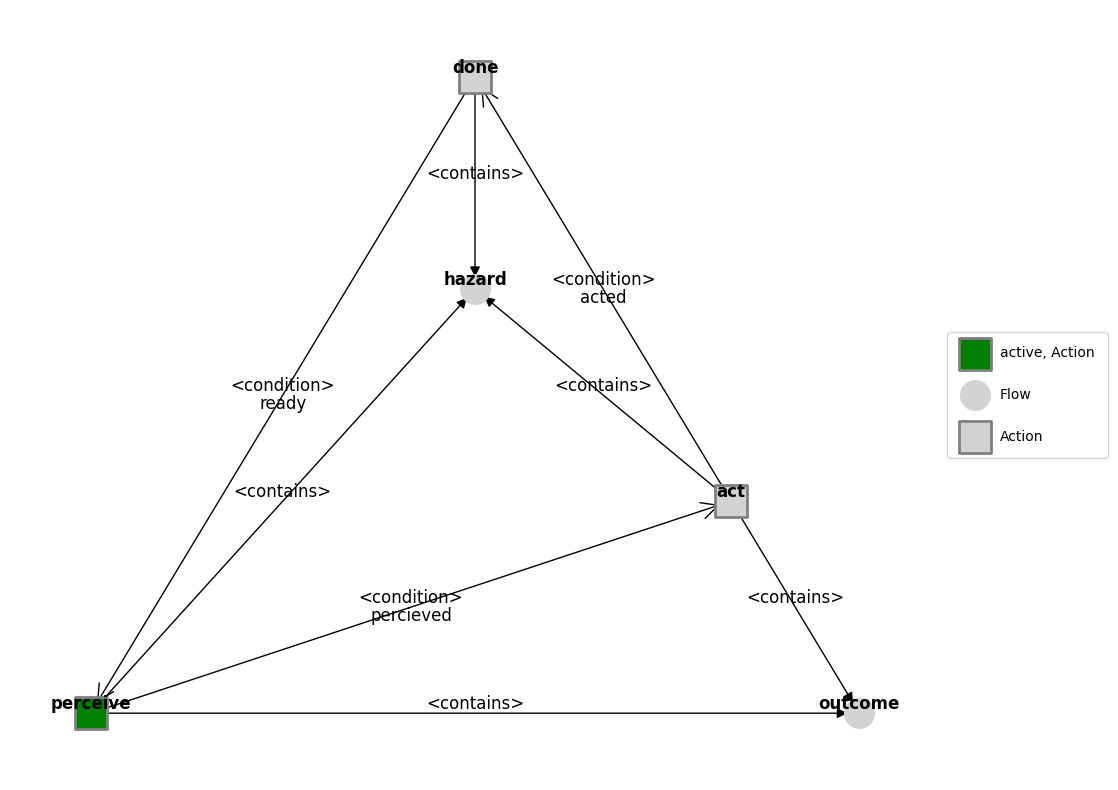

In [12]:
fig, ax = ag.draw()

As shown, the "Percieve" action is active (green), while the inactive actions are shown in blue. This action is active because it was defined as initial_action in the ASG definition.

These are stored as attributes in the underlying graph structure:

In [13]:
ag.g.nodes['perceive']

{'bipartite': 0, 'label': 'Action', 'active': True, 'states': {}, 'faults': []}

### Function-level Simulation

`ASG`s must be instantiated within a `FxnBlock` in order to be simulable with methods in `propagate`. Below we instantiate a `FxnBlock` and show how an `ASG` can be simulated independent of other Model attributes. 

In [14]:
class DetectHazard(FxnBlock):
    _init_a = Human
    _init_hazard= Hazard

If we update the action, we can see the ASG progress between states:

In [15]:
ex_fxn = DetectHazard('detect_hazard')
ex_fxn.t.dt=1.0

ex_fxn.a.flows['hazard']

hazard Hazard flow: HazardState(present=False, percieved=False, mitigated=False)

In [16]:
ex_fxn.a.flows['hazard'].s.present=True
ex_fxn('dynamic', time= 1)

(<Figure size 1200x1000 with 1 Axes>, <Axes: >)

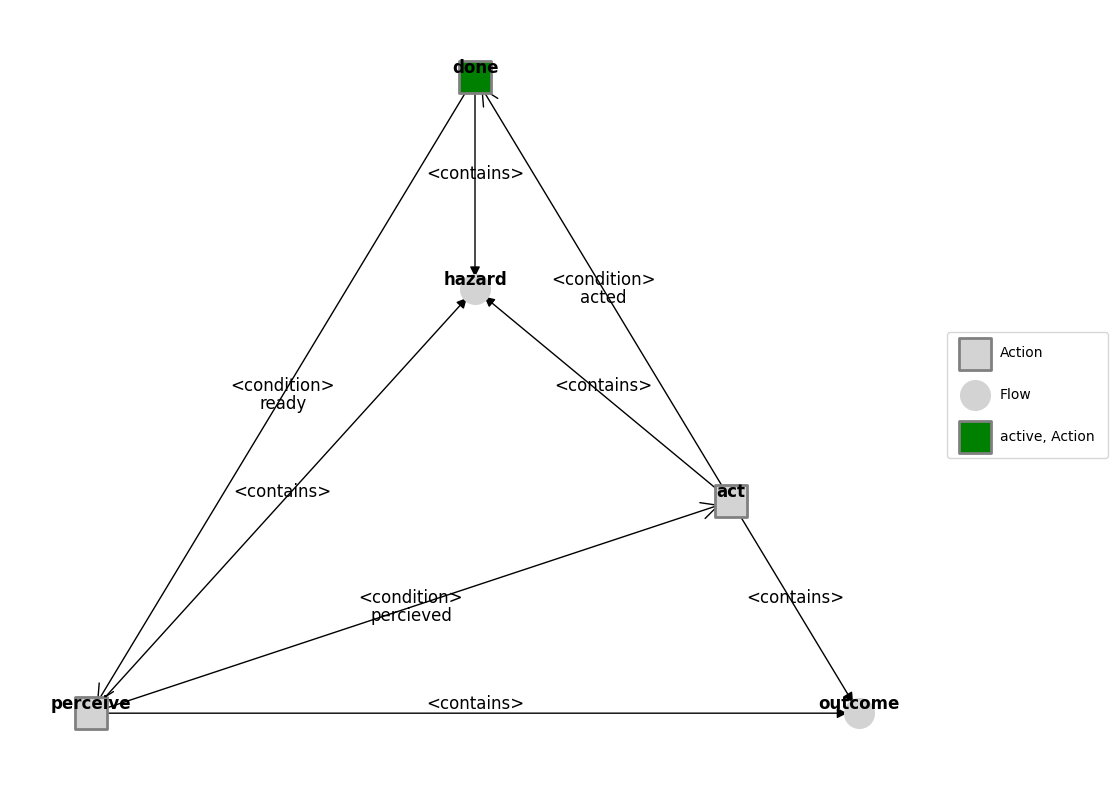

In [17]:
ag = ASGGraph(ex_fxn.a)
ag.draw()

In [18]:
ex_fxn.a.flows['hazard']

hazard Hazard flow: HazardState(present=True, percieved=True, mitigated=True)

In [19]:
assert ex_fxn.a.flows['hazard'].s.present

In [20]:
ex_fxn.a.flows['outcome']

outcome Outcome flow: OutcomeStates(num_perceptions=1, num_actions=1)

In [21]:
assert ex_fxn.a.flows['outcome'].s.num_perceptions==1
assert ex_fxn.a.flows['outcome'].s.num_actions==1

As shown, each of the actions are progressed throuh in a single timestep until the ASG is in the "Done" action

In [22]:
ex_fxn.a.flows['hazard'].s.present=False
ex_fxn('dynamic', time= 2)

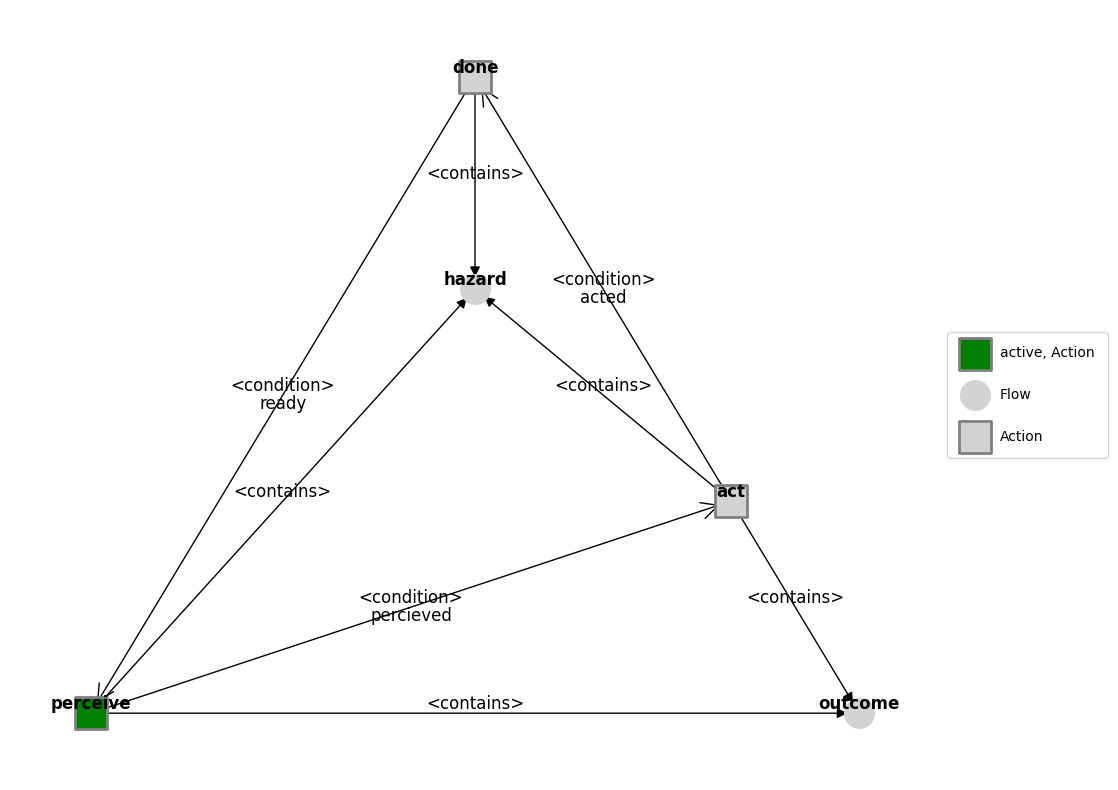

In [23]:
ag = ASGGraph(ex_fxn.a)
fig, ax = ag.draw()

As shown, now that the hazard is no longer present, the "Ready" Condition is triggered and the ASG goes back to the percieve state.

In [24]:
ex_fxn.a.flows['outcome']

outcome Outcome flow: OutcomeStates(num_perceptions=1, num_actions=1)

In [25]:
ex_fxn.a.flows['hazard']

hazard Hazard flow: HazardState(present=False, percieved=False, mitigated=False)

In [26]:
ex_fxn.hazard

hazard Hazard flow: HazardState(present=False, percieved=False, mitigated=False)

In [27]:
assert ex_fxn.a.flows['hazard'].s.present==False
assert ex_fxn.a.flows['hazard'].s.mitigated==False
assert id(ex_fxn.hazard) == id(ex_fxn.a.flows['hazard'])

This is essentially what a step-though of a simulation looks like. In practice, we simulate these behaviors using `propagate` as long as the `ASG` is contained in a `FxnBlock`. Here we use the `disturbances` argument to simulate an external hazard occuring at `t=5`:

In [28]:
result_indiv, hist_indiv = prop.nominal(ex_fxn, track="all", disturbances={5:{'a.flows.hazard.s.present':True}})

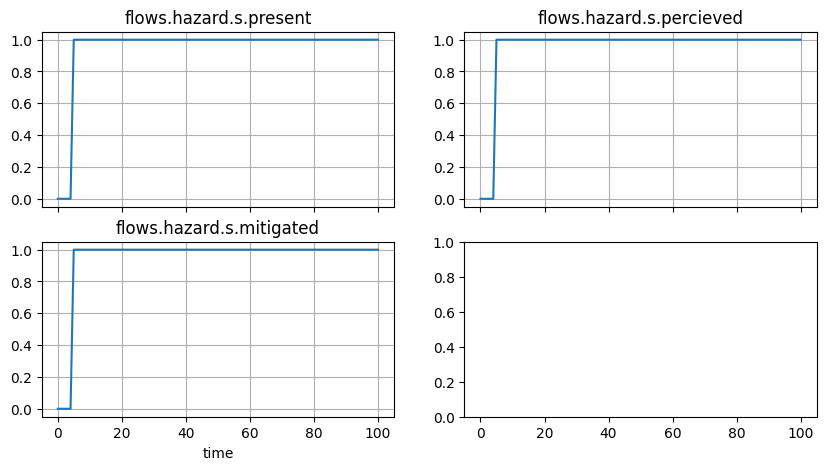

In [29]:
fig, axs = an.plot.hist(hist_indiv,'flows.hazard.s.present',
                                'flows.hazard.s.percieved',
                                'flows.hazard.s.mitigated', figsize=(10,5))

In [30]:
hist_indiv.a.active_actions

array([{'perceive'}, {'perceive'}, {'perceive'}, {'perceive'},
       {'perceive'}, {'done'}, {'done'}, {'done'}, {'done'}, {'done'},
       {'done'}, {'done'}, {'done'}, {'done'}, {'done'}, {'done'},
       {'done'}, {'done'}, {'done'}, {'done'}, {'done'}, {'done'},
       {'done'}, {'done'}, {'done'}, {'done'}, {'done'}, {'done'},
       {'done'}, {'done'}, {'done'}, {'done'}, {'done'}, {'done'},
       {'done'}, {'done'}, {'done'}, {'done'}, {'done'}, {'done'},
       {'done'}, {'done'}, {'done'}, {'done'}, {'done'}, {'done'},
       {'done'}, {'done'}, {'done'}, {'done'}, {'done'}, {'done'},
       {'done'}, {'done'}, {'done'}, {'done'}, {'done'}, {'done'},
       {'done'}, {'done'}, {'done'}, {'done'}, {'done'}, {'done'},
       {'done'}, {'done'}, {'done'}, {'done'}, {'done'}, {'done'},
       {'done'}, {'done'}, {'done'}, {'done'}, {'done'}, {'done'},
       {'done'}, {'done'}, {'done'}, {'done'}, {'done'}, {'done'},
       {'done'}, {'done'}, {'done'}, {'done'}, {'done'}, {'don

In [31]:
assert hist_indiv.flows.hazard.s.mitigated[5]
assert hist_indiv.a.active_actions[5]=={'done'}

### Model Simulation

Below, this function is placed in the context of a model so we can see how it behaves in the context of a simulation

In [32]:
class ProduceHazard(FxnBlock):
    __slots__=('hazard',)
    _init_hazard = Hazard
    def dynamic_behavior(self,time):
        if not time%4: self.hazard.s.present=True
        else:          self.hazard.s.present=False
class PassStates(State):
    hazards_mitigated:  int=0
    hazards_propagated: int=0
class PassHazard(FxnBlock):
    __slots__=('hazard',)
    _init_s = PassStates
    _init_hazard = Hazard
    def dynamic_behavior(self,time):
        if self.hazard.s.present and self.hazard.s.mitigated:       self.s.hazards_mitigated+=1
        elif self.hazard.s.present and not self.hazard.s.mitigated: self.s.hazards_propagated+=1

from fmdtools.define.parameter import Parameter
class HazardModel(Model):
    __slots__=()
    default_sp = dict(times=(0,60), dt=1.0)
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.add_flow("hazard", Hazard)
        
        self.add_fxn("produce_hazard", ProduceHazard, 'hazard')
        self.add_fxn("detect_hazard", DetectHazard, 'hazard')
        self.add_fxn("pass_hazard",  PassHazard, 'hazard')
        self.build()

As shown, this model connects the `detect_hazard` with a `detect_hazard` function, which are used (1) to load the system and then to (2) tabulate the number of mitigations.

Below we show how this translates into simulation results:

In [33]:
mdl = HazardModel()
endstate,  mdlhist = prop.nominal(mdl)

Below we look at the states of the functions/flows to see how this has simulated.

In [34]:
mdlhist

fxns.produce_hazard.m.mode:    array(61)
fxns.detect_hazard.a           array(61)
fxns.detect_hazard.a           array(61)
fxns.detect_hazard.a           array(61)
fxns.detect_hazard.a           array(61)
fxns.detect_hazard.a           array(61)
fxns.detect_hazard.a           array(61)
fxns.detect_hazard.a           array(61)
fxns.detect_hazard.a.active_actions: array(61)
fxns.detect_hazard.m           array(61)
fxns.detect_hazard.m           array(61)
fxns.detect_hazard.m.faults.act_failed: array(61)
fxns.detect_hazard.m.faults.act_unable: array(61)
fxns.detect_hazard.m.mode:     array(61)
fxns.pass_hazard.s.hazards_mitigated: array(61)
fxns.pass_hazard.s.hazards_propagated: array(61)
fxns.pass_hazard.m.mode:       array(61)
flows.hazard.s.present:        array(61)
flows.hazard.s.percieved:      array(61)
flows.hazard.s.mitigated:      array(61)
time:                          array(61)

In [35]:
restab = mdlhist.get('fxns.detect_hazard.a.active_actions', 'flows.hazard.s').as_table()

In [36]:
restab

,fxns.detect_hazard.a.active_actions,flows.hazard.s.present,flows.hazard.s.percieved,flows.hazard.s.mitigated
0,{perceive},False,False,False
1,{perceive},False,False,False
2,{perceive},False,False,False
3,{perceive},False,False,False
4,{done},True,True,True
...,...,...,...,...
56,{done},True,True,True
57,{perceive},False,False,False
58,{perceive},False,False,False
59,{perceive},False,False,False


As shown, the ASG alternates between Perceive (when the hazard is not present) and Done (when the hazard is present). As a result, all of the present hazards (above) are also perceived and mitigated, and no hazards are propagated.

Or, in plot form:

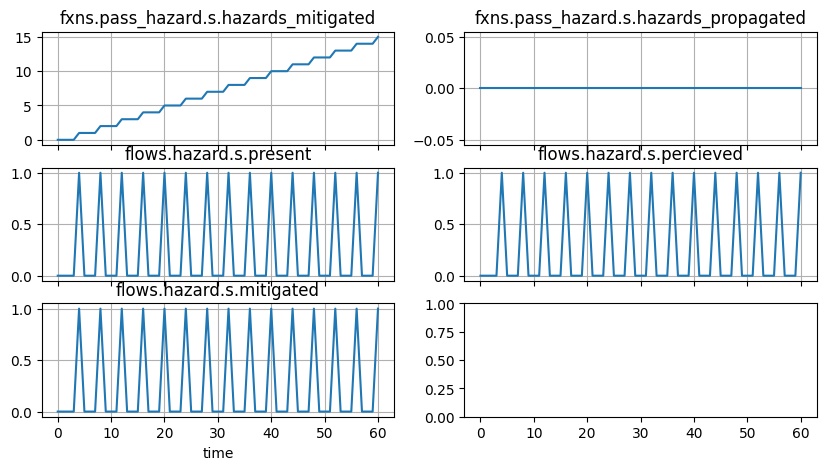

In [37]:
fig, axs = an.plot.hist(mdlhist, 'fxns.pass_hazard.s.hazards_mitigated',
                                'fxns.pass_hazard.s.hazards_propagated',
                                'flows.hazard.s.present',
                                'flows.hazard.s.percieved',
                                'flows.hazard.s.mitigated', figsize=(10,5))

As shown, perceptions and actions track the hazards mitigated.

### Fault Simulation
Below we will simulate a fault and see how it tracks in the model.

In [38]:
result_fault, mdlhist_fault = prop.one_fault(mdl, 'detect_hazard','perceive_failed', time=4, desired_result='graph')

In [39]:
mdlhist_fault.faulty.fxns.detect_hazard.a.actions.act

m.faults.failed:               array(61)
m.faults.unable:               array(61)
m.mode:                        array(61)

As shown, this fault results in the hazard not being perceived (and thus the hazard propagating)

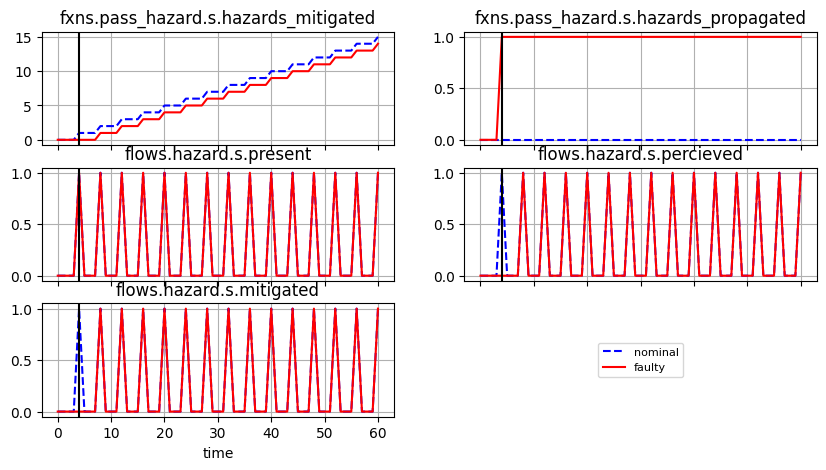

In [40]:
fig, axs = an.plot.hist(mdlhist_fault, 'fxns.pass_hazard.s.hazards_mitigated',
                                'fxns.pass_hazard.s.hazards_propagated',
                                'flows.hazard.s.present',
                                'flows.hazard.s.percieved',
                                'flows.hazard.s.mitigated', figsize=(10,5), time_slice=[4])

As shown, this only shows up in the PassHazard function (since the fault is removed in one timestep).

(<Figure size 1200x1000 with 1 Axes>, <Axes: >)

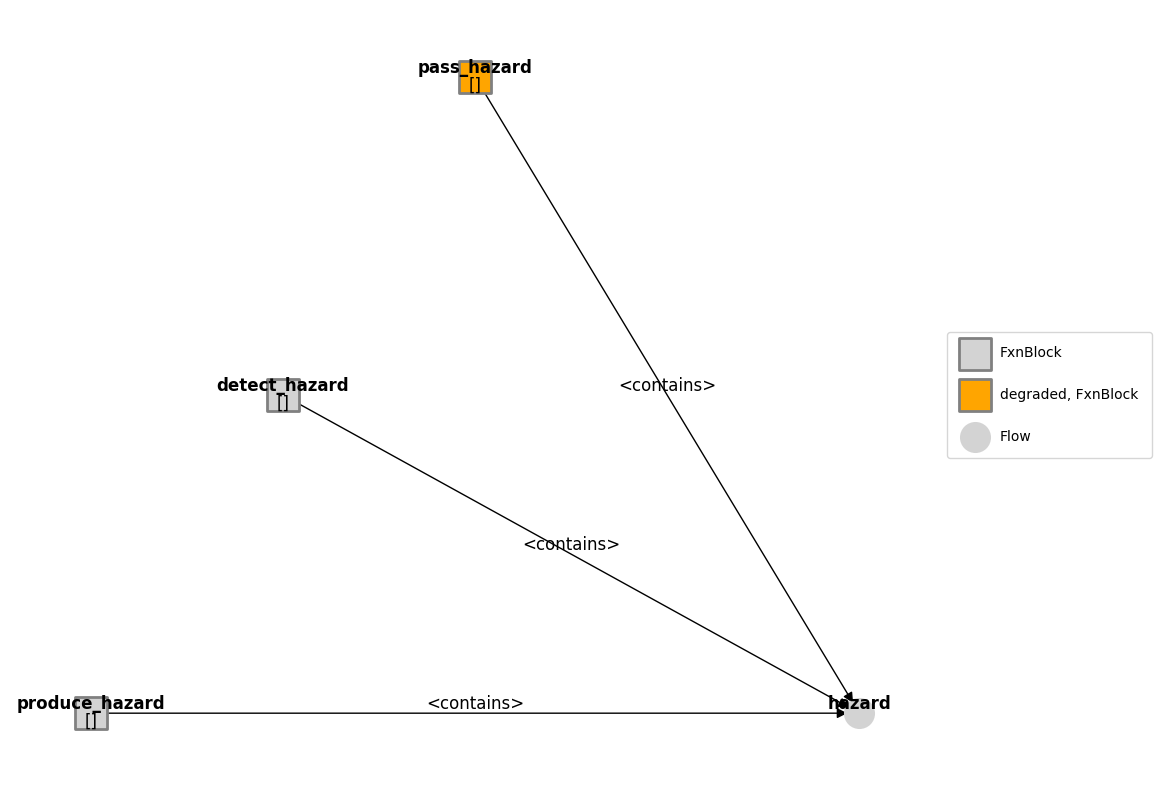

In [41]:
result_fault.graph.draw()

To see this in more detail, we will process the results history and then use `graph.results_from` at the time of the fault. Note how the model histories can be processed below:

In [42]:
reshist = mdlhist_fault.get_degraded_hist(*mdl.fxns, *mdl.flows)
reshist.as_table()

,produce_hazard,detect_hazard,pass_hazard,hazard,total,time
0,1,1,1,1,0,0.0
1,1,1,1,1,0,1.0
2,1,1,1,1,0,2.0
3,1,1,1,1,0,3.0
4,1,0,0,0,3,4.0
...,...,...,...,...,...,...
56,1,0,0,0,3,56.0
57,1,0,0,0,3,57.0
58,1,0,0,0,3,58.0
59,1,0,0,0,3,59.0


In [43]:
reshist = mdlhist_fault.get_faulty_hist(*mdl.fxns, *mdl.flows)
reshist.as_table()

,detect_hazard,total,time
0,False,0,0.0
1,False,0,1.0
2,False,0,2.0
3,False,0,3.0
4,False,0,4.0
...,...,...,...
56,False,0,56.0
57,False,0,57.0
58,False,0,58.0
59,False,0,59.0


We can further use `draw_from` to view the state of the ASG. See below:

(<Figure size 1200x1000 with 1 Axes>, <Axes: title={'center': ' t=4'}>)

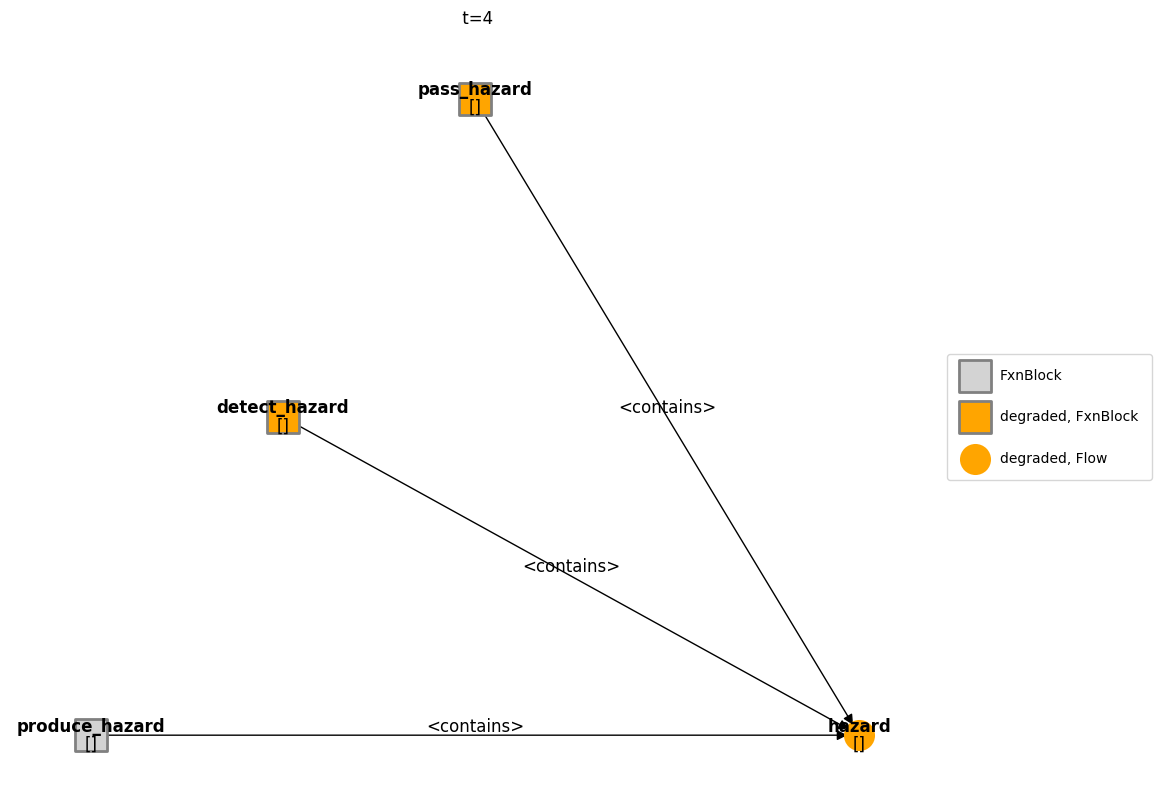

In [44]:
result_fault.graph.draw_from(4, mdlhist_fault)

Note the lack of a fault at this time-step, despite it being instantiated here. This is because the fault was removed at the end of the same time-step it was added in.

The 'unable' fault, on the other hand, stays throughout the simulation and thus shows up:

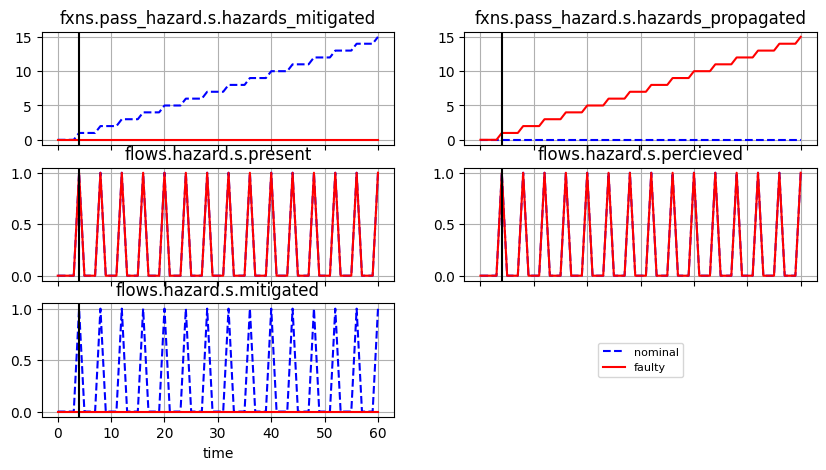

In [45]:
endstate_unable, mdlhist_unable = prop.one_fault(mdl, 'detect_hazard','act_unable', time=4, 
                                                 desired_result={'graph','graph.fxns.detect_hazard.a'}, track='all')
#reshist_unable, diff_unable, summary_unable = an.process.hist(mdlhist_unable)
fig, axs = an.plot.hist(mdlhist_unable, 'fxns.pass_hazard.s.hazards_mitigated',
                                'fxns.pass_hazard.s.hazards_propagated',
                                'flows.hazard.s.present',
                                'flows.hazard.s.percieved',
                                'flows.hazard.s.mitigated', 
                            figsize=(10,5), time_slice=[4])

(<Figure size 1200x1000 with 1 Axes>, <Axes: title={'center': ' t=4'}>)

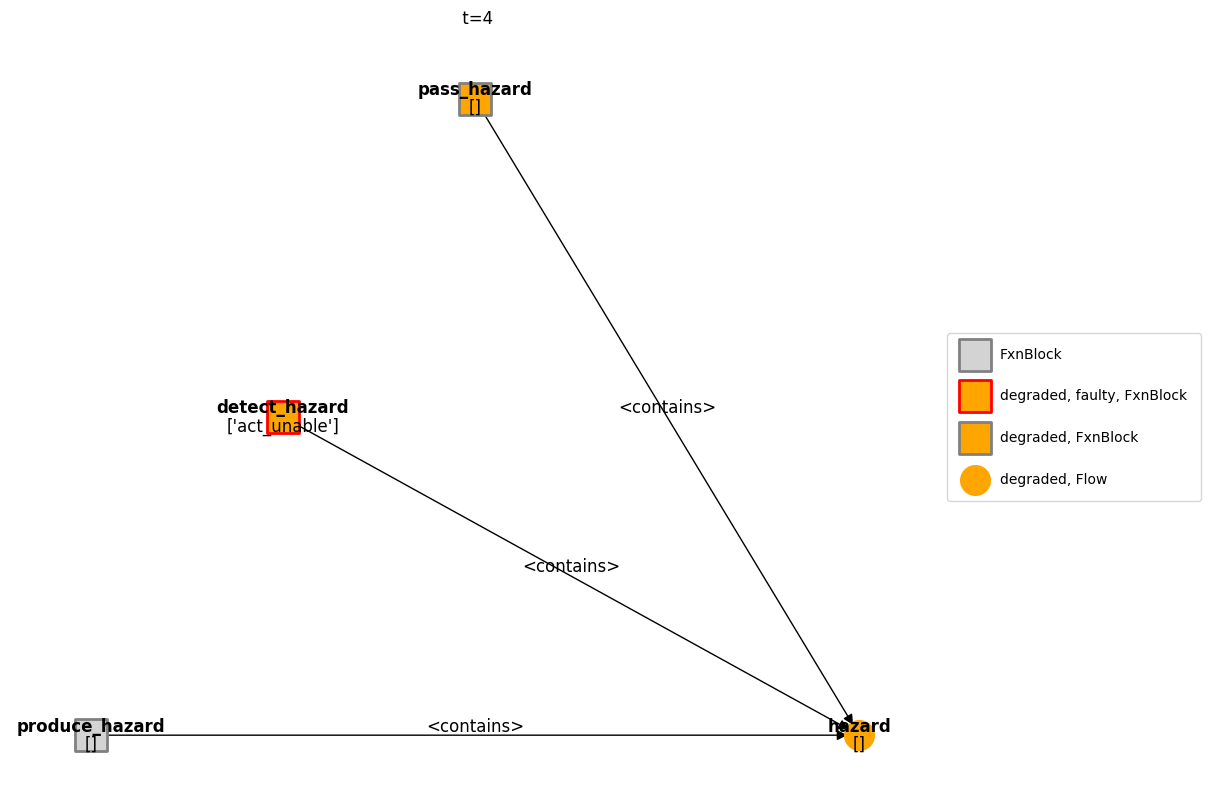

In [46]:
endstate_unable.graph.draw_from(4, mdlhist_unable)

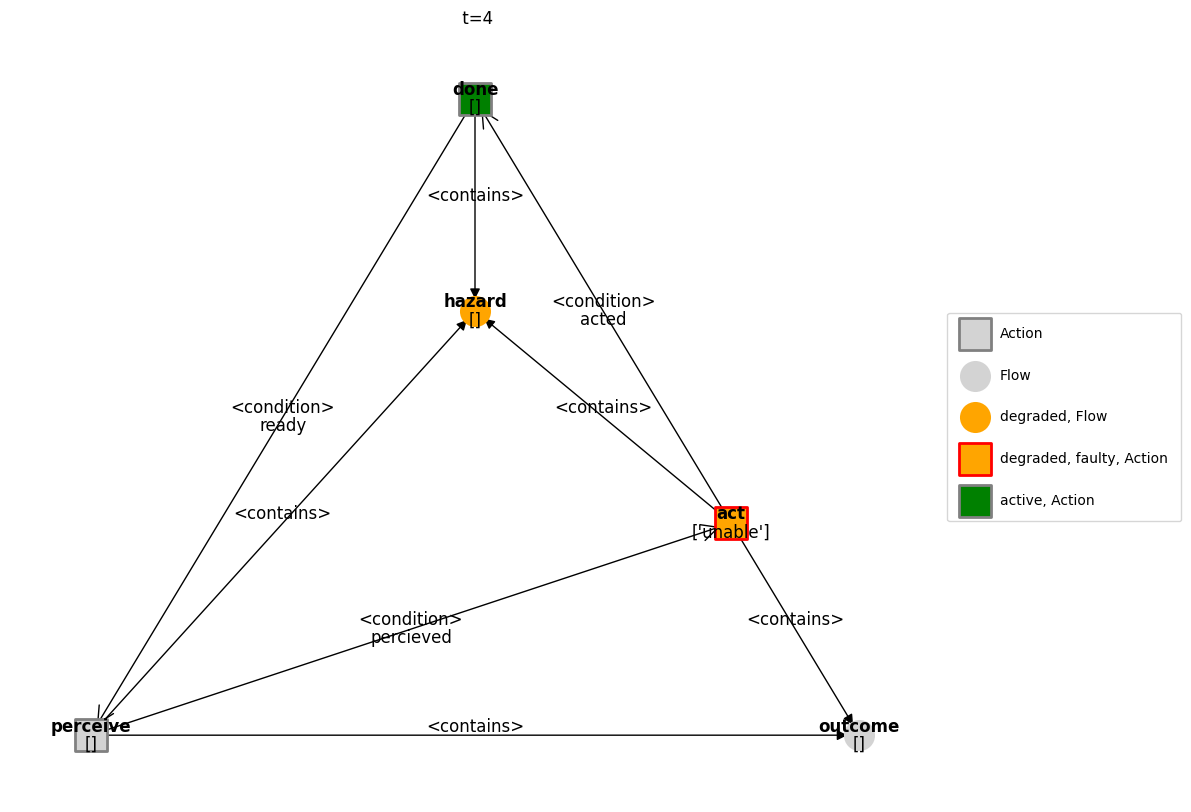

In [47]:
fig, ax = endstate_unable['graph.fxns.detect_hazard.a'].draw_from(4, mdlhist_unable)

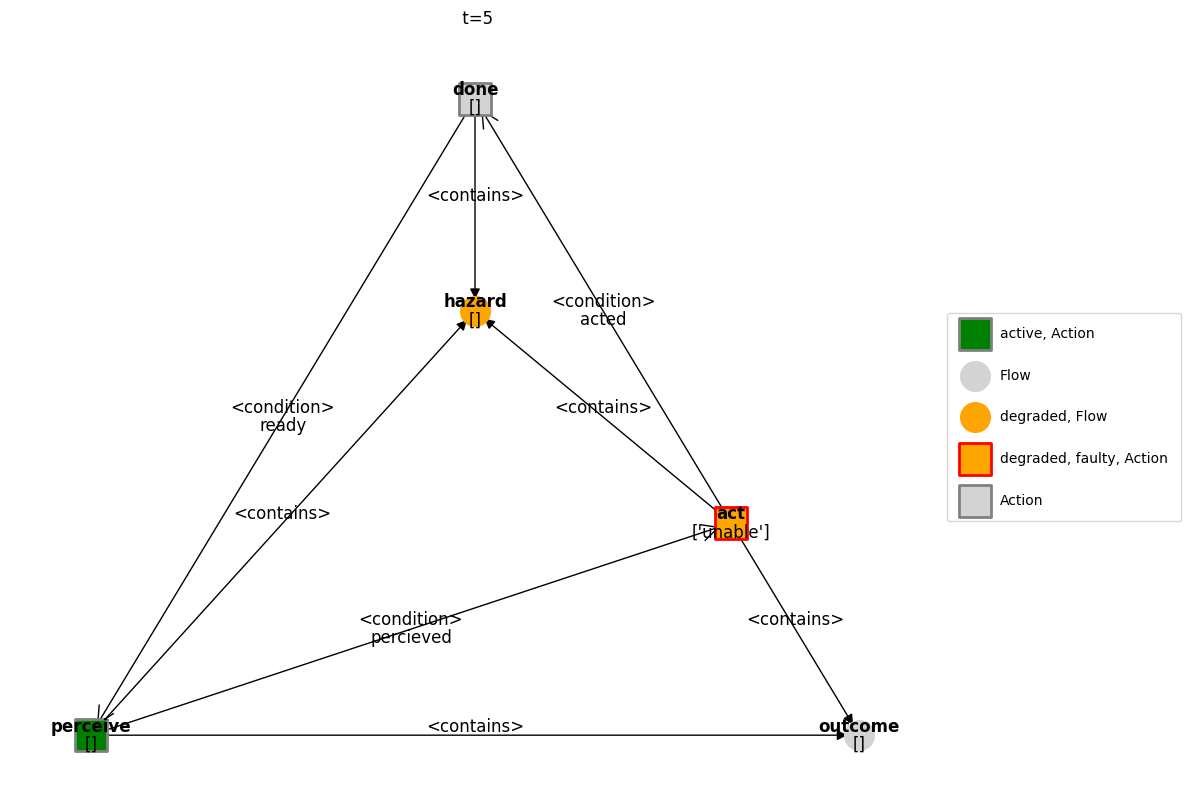

In [48]:
fig, ax = endstate_unable['graph.fxns.detect_hazard.a'].draw_from(5, mdlhist_unable)